### Load libraries & datasets

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import preprocessing

In [2]:
cust_data_file = pd.read_csv("C:/Users/Dexter/Desktop/Mrunal/Webflow take-home/customers.csv")
subscr_data_file = pd.read_csv("C:/Users/Dexter/Desktop/Mrunal/Webflow take-home/subscriptions.csv")
weekly_subscr_data_file = pd.read_csv("C:/Users/Dexter/Desktop/Mrunal/Webflow take-home/weekly_subscription_movements.csv")

### Explore datasets

In [3]:
cust_data_file.describe() 

# unique at customer_id
# 1) duplicate in user_id and customer_created_at columns 
# 2) count(customer_id) != count(user_id) => 140,456
# 3) missing user_created_at for unique user_id

,CUSTOMER_ID,CUSTOMER_CREATED_AT,USER_ID,USER_CREATED_AT,ORG_ID,HAS_DEFAULT_CARD
count,140456,140456,131515,130323,8941,140456
unique,140456,132715,130507,124496,8928,2
top,cus_I4S5AT1MQEK562,2019-04-11 16:19,5e31f70a5b016d0b7e2b482c,2014-01-23 18:48,5f612aa32b38327ae9719e70,True
freq,1,5,3,8,2,130442


In [4]:
subscr_data_file.describe()

# unique at subscription_id. Customer_id is the foreign_key
# 1) has 139,091 customer_id to map with 140,456 customer_id in the customers table
# 2) Is subscr.created_at = cust.user_created_at?
# plan_dedup_df=subscr_data_file.drop_duplicates(['PLAN_OBJECT_TIER','PLAN_OBJECT_TYPE'])[['PLAN_OBJECT_TIER','PLAN_OBJECT_TYPE']]
# plan_dedup_df.sort_values(by = ['PLAN_OBJECT_TIER','PLAN_OBJECT_TYPE']).head(100)
# 3) 48,357 records have missing plan_object_tier and type

,SUBSCRIPTION_ID,CUSTOMER_ID,CREATED_AT,CANCELED_AT,PLAN_INTERVAL,PLAN_OBJECT_ID,PLAN_OBJECT_TIER,PLAN_OBJECT_TYPE
count,295936,295936,295936,143366,295936,295936,295935,295935
unique,295936,139091,263585,130314,2,265412,10,4
top,sub_Ar5MLtZQYJYdh4,cus_Cad0J86GyFUodu,2015-10-27 07:08,2020-07-08 10:07,month,user_account_plan__575fcb9e4068168e111735ba,site_plan_cms,site_plan
freq,1,376,39,62,203333,16,123244,205841


In [5]:
weekly_subscr_data_file.drop(['Unnamed: 0'], axis = 1, inplace = True)
weekly_subscr_data_file.head() # has first column name as Unnamed:0 --> removed using - drop(['Unnamed: 0'], axis = 1, inplace = True)
# 41 weeks of weekly subscription movement data available. Subscription_id is foreign_key
# 1) 226,836 subscription information available

,WEEK,SUBSCRIPTION_ID,IS_ACTIVE,IS_NEW,IS_CANCEL
0,2020-05-25,sub_H35M6Gpf3gAPPx,True,False,False
1,2020-05-25,sub_9S4WuaMDRFwUYU,True,False,False
2,2020-09-21,sub_9S4WuaMDRFwUYU,True,False,False
3,2020-04-13,sub_GUiGn8DUWRYcHd,True,False,False
4,2020-09-14,sub_HbSobH4PUnPlfL,True,False,False


### Top-down approach:  
##### 1) Overall account health in given database: Split by continuing and discontinued subscription. Defined as:
#####       a]   Continuing -  subscription cancellation date is not available in the 'CANCELED_AT' column
#####       b]   Discontinued - subscription cancellation data is available 
### Establishing baseline tenure and top plan for at WEBFLOW
##### 2)  Tenure of discontinued subscriptions: 'CANCELED_AT' minus 'CREATED_AT' converted to months bucketed into
######   ["0-3", "3-6", "6-9", "9-12","12-18", "18-24", "24+"]
##### 3) Discontinued subscriptions by Tenure and Plan type
### Deep diving into weekly movements of subscriptions
##### 4) Weekly cancellations by plan type 
##### 5) Weekly cancellations by tenure




### Pre-calculations for customer tenure and customer type 

In [6]:
subscr_data_file.dtypes
subscr_data_file['CANCELED_AT'] = pd.to_datetime(subscr_data_file['CANCELED_AT'], errors='coerce')
subscr_data_file['CREATED_AT'] = pd.to_datetime(subscr_data_file['CREATED_AT'], errors='coerce')

In [31]:
subscr_data_file['CUSTOMER_TENURE'] = (subscr_data_file['CANCELED_AT'] - subscr_data_file['CREATED_AT']).dt.total_seconds() / 60 / 60 / 24 / 30
subscr_data_file.head(5)

,SUBSCRIPTION_ID,CUSTOMER_ID,CREATED_AT,CANCELED_AT,PLAN_INTERVAL,PLAN_OBJECT_ID,PLAN_OBJECT_TIER,PLAN_OBJECT_TYPE,CUSTOMER_TENURE,CUSTOMER_TYPE,CUST_TENURE_BUCKET
0,sub_CoXGvebRm4ihLn,cus_CoXGAtW96mySnF,2018-05-06 21:14:00,NaT,year,site_plan__5adbec8fd6a39313696826bd,site_plan_cms,site_plan,NaN,Continuing,NaN
1,sub_DNoVvgigmBTgoq,cus_CEilYSOkpRkXck,2018-08-09 01:23:00,2019-01-08 15:23:00,month,site_plan__5b6b934c41c61665a16a7575,site_plan_cms,site_plan,5.086111,Discontinued,3-6
2,sub_AItFTrRiB8Fwx3,cus_6zKVmsLQhteq7D,2017-03-17 09:34:00,2020-07-15 11:13:00,month,site_plan__58c09a495832e2db0adc7d5d,site_plan_cms,site_plan,40.535625,Discontinued,24+
3,sub_GA0JVpCy30PuWT,cus_GA0JJspjYTnQGf,2019-11-11 17:03:00,2020-06-15 04:42:00,month,user_account_plan__5dc0a89602f22266b0cd72da,user_account_professional,user_account_plan,7.216181,Discontinued,6-9
4,sub_I6GL0Nk4jwUIYq,cus_I6FPRknB171s3I,2020-09-27 17:38:00,NaT,month,site_plan__5f70c0b210f59917f12832bb,site_plan_cms,site_plan,NaN,Continuing,NaN


In [32]:
subscr_data_file['CUSTOMER_TYPE'] = subscr_data_file['CUSTOMER_TENURE'].apply(lambda x:'Continuing' if math.isnan(x) else 'Discontinued')
subscr_data_file.head(5)

,SUBSCRIPTION_ID,CUSTOMER_ID,CREATED_AT,CANCELED_AT,PLAN_INTERVAL,PLAN_OBJECT_ID,PLAN_OBJECT_TIER,PLAN_OBJECT_TYPE,CUSTOMER_TENURE,CUSTOMER_TYPE,CUST_TENURE_BUCKET
0,sub_CoXGvebRm4ihLn,cus_CoXGAtW96mySnF,2018-05-06 21:14:00,NaT,year,site_plan__5adbec8fd6a39313696826bd,site_plan_cms,site_plan,NaN,Continuing,NaN
1,sub_DNoVvgigmBTgoq,cus_CEilYSOkpRkXck,2018-08-09 01:23:00,2019-01-08 15:23:00,month,site_plan__5b6b934c41c61665a16a7575,site_plan_cms,site_plan,5.086111,Discontinued,3-6
2,sub_AItFTrRiB8Fwx3,cus_6zKVmsLQhteq7D,2017-03-17 09:34:00,2020-07-15 11:13:00,month,site_plan__58c09a495832e2db0adc7d5d,site_plan_cms,site_plan,40.535625,Discontinued,24+
3,sub_GA0JVpCy30PuWT,cus_GA0JJspjYTnQGf,2019-11-11 17:03:00,2020-06-15 04:42:00,month,user_account_plan__5dc0a89602f22266b0cd72da,user_account_professional,user_account_plan,7.216181,Discontinued,6-9
4,sub_I6GL0Nk4jwUIYq,cus_I6FPRknB171s3I,2020-09-27 17:38:00,NaT,month,site_plan__5f70c0b210f59917f12832bb,site_plan_cms,site_plan,NaN,Continuing,NaN


### 1. Overall account health (Subscriptions database)

In [33]:
df2 = subscr_data_file.groupby(['CUSTOMER_TYPE'])['SUBSCRIPTION_ID'].size().reset_index(name='SUBSCR_COUNTS')
df2.head()

,CUSTOMER_TYPE,SUBSCR_COUNTS
0,Continuing,152570
1,Discontinued,143366


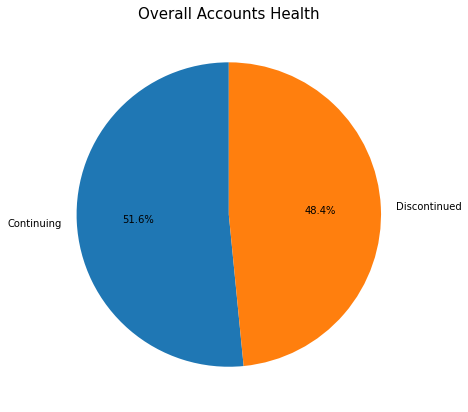

In [38]:
CUST_TYPE = df2['CUSTOMER_TYPE']
SUBSCR = df2['SUBSCR_COUNTS']
 
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(SUBSCR, labels = CUST_TYPE, autopct='%1.1f%%', startangle=90)
 
# show plot
plt.title("Overall Accounts Health", fontsize = 15)
plt.show()

### 2. Tenure of discontinued subscriptions (48.4% Discontinued accounts tenure with Webflow)

In [39]:
bins = [0,3, 6, 9, 12, 18, 24, np.inf]
labels = ["0-3", "3-6", "6-9", "9-12","12-18", "18-24", "24+"]
subscr_data_file['CUST_TENURE_BUCKET'] = pd.cut(subscr_data_file['CUSTOMER_TENURE'], bins=bins, labels=labels)
subscr_data_file.head(5)

,SUBSCRIPTION_ID,CUSTOMER_ID,CREATED_AT,CANCELED_AT,PLAN_INTERVAL,PLAN_OBJECT_ID,PLAN_OBJECT_TIER,PLAN_OBJECT_TYPE,CUSTOMER_TENURE,CUSTOMER_TYPE,CUST_TENURE_BUCKET
0,sub_CoXGvebRm4ihLn,cus_CoXGAtW96mySnF,2018-05-06 21:14:00,NaT,year,site_plan__5adbec8fd6a39313696826bd,site_plan_cms,site_plan,NaN,Continuing,NaN
1,sub_DNoVvgigmBTgoq,cus_CEilYSOkpRkXck,2018-08-09 01:23:00,2019-01-08 15:23:00,month,site_plan__5b6b934c41c61665a16a7575,site_plan_cms,site_plan,5.086111,Discontinued,3-6
2,sub_AItFTrRiB8Fwx3,cus_6zKVmsLQhteq7D,2017-03-17 09:34:00,2020-07-15 11:13:00,month,site_plan__58c09a495832e2db0adc7d5d,site_plan_cms,site_plan,40.535625,Discontinued,24+
3,sub_GA0JVpCy30PuWT,cus_GA0JJspjYTnQGf,2019-11-11 17:03:00,2020-06-15 04:42:00,month,user_account_plan__5dc0a89602f22266b0cd72da,user_account_professional,user_account_plan,7.216181,Discontinued,6-9
4,sub_I6GL0Nk4jwUIYq,cus_I6FPRknB171s3I,2020-09-27 17:38:00,NaT,month,site_plan__5f70c0b210f59917f12832bb,site_plan_cms,site_plan,NaN,Continuing,NaN


In [35]:
df_cust_tenure = subscr_data_file.groupby(['CUST_TENURE_BUCKET'])['SUBSCRIPTION_ID'].size().reset_index(name='SUBSCR_COUNTS')
df_cust_tenure.head(5)

,CUST_TENURE_BUCKET,SUBSCR_COUNTS
0,0-3,69111
1,3-6,22024
2,6-9,11597
3,9-12,8491
4,12-18,14258


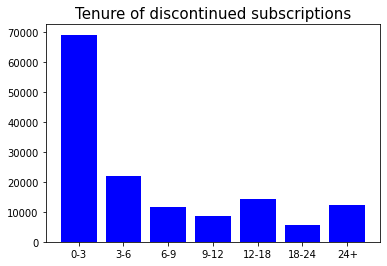

In [42]:
# Horizontal Bar Plot
plt.bar(df_cust_tenure['CUST_TENURE_BUCKET'], df_cust_tenure['SUBSCR_COUNTS'], color = 'b')
 
# Show Plot
plt.title("Tenure of discontinued subscriptions", fontsize = 15)
plt.show()

### 3. Discontinued subscription by tenure and plan type

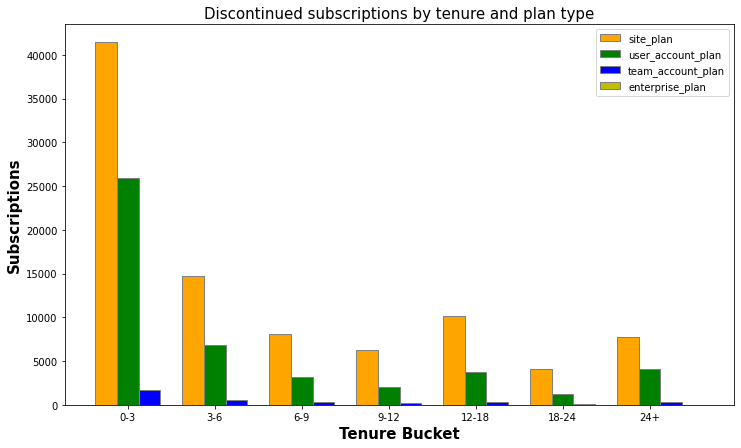

In [71]:
df_cust_tenure_plan = subscr_data_file.groupby(['CUST_TENURE_BUCKET','PLAN_OBJECT_TYPE'])['SUBSCRIPTION_ID'].size().reset_index(name='SUBSCR_COUNTS')
# df_cust_tenure11.head(75)

barWidth = 0.25
fig = plt.subplots(figsize =(12, 7))

# Set position of bar on X axis
br1 = np.arange(7)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, df_cust_tenure_plan[df_cust_tenure_plan['PLAN_OBJECT_TYPE']=='site_plan']['SUBSCR_COUNTS'], color ='orange', width = barWidth,
        edgecolor ='grey', label ='site_plan')
plt.bar(br2, df_cust_tenure_plan[df_cust_tenure_plan['PLAN_OBJECT_TYPE']=='user_account_plan']['SUBSCR_COUNTS'], color ='g', width = barWidth,
        edgecolor ='grey', label ='user_account_plan')
plt.bar(br3, df_cust_tenure_plan[df_cust_tenure_plan['PLAN_OBJECT_TYPE']=='team_account_plan']['SUBSCR_COUNTS'], color ='b', width = barWidth,
        edgecolor ='grey', label ='team_account_plan')
plt.bar(br4, df_cust_tenure_plan[df_cust_tenure_plan['PLAN_OBJECT_TYPE']=='enterprise_plan']['SUBSCR_COUNTS'], color ='y', width = barWidth,
        edgecolor ='grey', label ='enterprise_plan')
 
# Adding Xticks
plt.xlabel('Tenure Bucket', fontweight ='bold', fontsize = 15)
plt.ylabel('Subscriptions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(7)],
        ['0-3', '3-6', '6-9', '9-12','12-18', '18-24', '24+'])
 
plt.legend()
plt.title("Discontinued subscriptions by tenure and plan type", fontsize = 15)
plt.show()

# enterprise plan is all 0

### Pre-calculation: Merge weekly subscription, subscription and customer data files

In [19]:
weekly_subscr_cancel_data = weekly_subscr_data_file[weekly_subscr_data_file['IS_CANCEL'] == True][['WEEK','SUBSCRIPTION_ID']]
weekly_subscr_cancel_data.describe()
# weekly_subscr_data_file['IS_CANCEL']

,WEEK,SUBSCRIPTION_ID
count,57027,57027
unique,41,57027
top,2020-09-28,sub_GwhfwVQWB8z17P
freq,1871,1


In [20]:
weekly_plan_lvl_cancel = pd.merge(weekly_subscr_cancel_data, subscr_data_file, on='SUBSCRIPTION_ID', how='inner', suffixes =("","_SUB"))
drops = ['CREATED_AT','CANCELED_AT','PLAN_OBJECT_ID'] #'SUBSCRIPTION_ID_SUB'
weekly_plan_lvl_cancel.drop(drops, inplace=True, axis=1)


weekly_plan_cust_cancel = pd.merge(weekly_plan_lvl_cancel, cust_data_file, on='CUSTOMER_ID', how='inner', suffixes =("","_CUST"))
drops = ['CUSTOMER_CREATED_AT', 'USER_ID', 'USER_CREATED_AT', 'HAS_DEFAULT_CARD'] #, 'CUSTOMER_ID_CUST'
weekly_plan_cust_cancel.drop(drops, inplace=True, axis=1)

weekly_plan_cust_cancel.head()

,WEEK,SUBSCRIPTION_ID,CUSTOMER_ID,PLAN_INTERVAL,PLAN_OBJECT_TIER,PLAN_OBJECT_TYPE,CUSTOMER_TENURE,CUSTOMER_TYPE,CUST_TENURE_BUCKET,ORG_ID
0,2020-03-02,sub_GCZrl88k3dSfRL,cus_DL1R79Awjwz3K7,month,site_plan_business,site_plan,3.594907,Discontinued,3-6,5b61c4d3ba70069d17d9ec97
1,2020-03-09,sub_FpdYWm1enVySSC,cus_DL1R79Awjwz3K7,month,site_plan_business,site_plan,5.883218,Discontinued,3-6,5b61c4d3ba70069d17d9ec97
2,2020-03-09,sub_FbmIXmbQYk0QHr,cus_DL1R79Awjwz3K7,month,site_plan_business,site_plan,7.116551,Discontinued,6-9,5b61c4d3ba70069d17d9ec97
3,2020-08-31,sub_G0sxQXQHqRYuZd,cus_DL1R79Awjwz3K7,month,site_plan_business,site_plan,10.702523,Discontinued,9-12,5b61c4d3ba70069d17d9ec97
4,2020-08-31,sub_FpL5dja085w588,cus_DL1R79Awjwz3K7,month,site_plan_business,site_plan,11.729931,Discontinued,9-12,5b61c4d3ba70069d17d9ec97


### Active and Cancelled subscriptions weekly trend

In [27]:
weekly_subscr_active_data = weekly_subscr_data_file[weekly_subscr_data_file['IS_ACTIVE'] == True][['WEEK','SUBSCRIPTION_ID']]
weekly_subscr_active_data = weekly_subscr_active_data.drop_duplicates(['WEEK','SUBSCRIPTION_ID'])
weekly_subscr_active_data.describe()
# weekly_subscr_data_file['IS_CANCEL']

,WEEK,SUBSCRIPTION_ID
count,5196820,5196820
unique,41,215756
top,2020-09-28,sub_FkqQCq2EBtBO7d
freq,157872,41


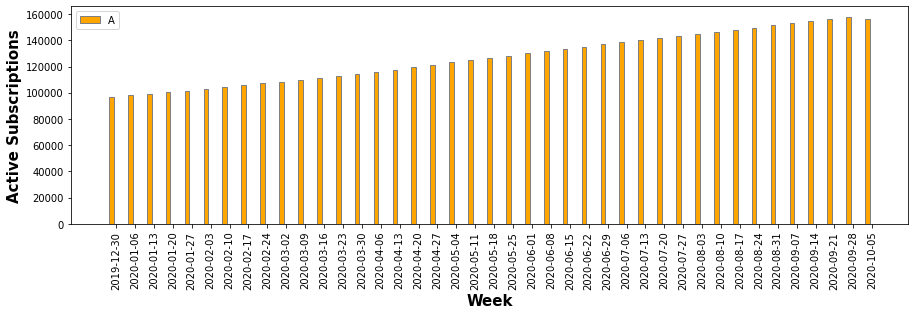

In [69]:
weekly_subscr_active_data1 = weekly_subscr_active_data.groupby(['WEEK'])['SUBSCRIPTION_ID'].size().reset_index(name='SUBSCR_COUNTS')
# df_cust_tenure11.head(75)

weekly_subscr_xaxis = weekly_subscr_active_data1.drop_duplicates(['WEEK']).sort_values(by = ['WEEK'])['WEEK']

barWidth = 0.25
fig = plt.subplots(figsize =(15, 4))

# Set position of bar on X axis
br1 = np.arange(41)
 
# Make the plot
plt.bar(br1, weekly_subscr_active_data1['SUBSCR_COUNTS'], color ='orange', width = barWidth,
        edgecolor ='grey')
 
# Adding Xticks
plt.xlabel('Week', fontweight ='bold', fontsize = 15)
plt.ylabel('Active Subscriptions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(41)], weekly_subscr_xaxis, fontsize = 10, rotation = 90 )
 
plt.legend('Active Subscriptions')
plt.show()


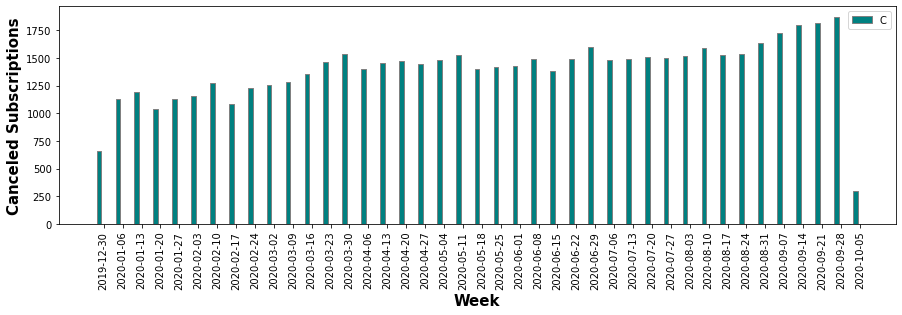

In [70]:
weekly_subscr_cancel_data1 = weekly_subscr_cancel_data.groupby(['WEEK'])['SUBSCRIPTION_ID'].size().reset_index(name='SUBSCR_COUNTS')
# df_cust_tenure11.head(75)

weekly_subscr_xaxis = weekly_subscr_cancel_data1.drop_duplicates(['WEEK']).sort_values(by = ['WEEK'])['WEEK']

barWidth = 0.25
fig = plt.subplots(figsize =(15, 4))

# Set position of bar on X axis
br1 = np.arange(41)
 
# Make the plot
plt.bar(br1, weekly_subscr_cancel_data1['SUBSCR_COUNTS'], color ='teal', width = barWidth,
        edgecolor ='grey')
 
# Adding Xticks
plt.xlabel('Week', fontweight ='bold', fontsize = 15)
plt.ylabel('Canceled Subscriptions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(41)], weekly_subscr_xaxis, fontsize = 10, rotation = 90 )
 
plt.legend('Canceled Subscriptions')
plt.show()


### 4. Weekly Cancellations by plan type 

In [51]:
df_plan = weekly_plan_cust_cancel.groupby(['WEEK','PLAN_OBJECT_TYPE'])['SUBSCRIPTION_ID'].size().reset_index(name='SUBSCR_COUNTS')
df_plan.head(5)

,WEEK,PLAN_OBJECT_TYPE,SUBSCR_COUNTS
0,2019-12-30,site_plan,411
1,2019-12-30,team_account_plan,13
2,2019-12-30,user_account_plan,231
3,2020-01-06,site_plan,763
4,2020-01-06,team_account_plan,29


In [52]:
df_plan_week = df_plan.drop_duplicates(['WEEK']).sort_values(by = ['WEEK'])['WEEK']
# df_plan_week.head(50)

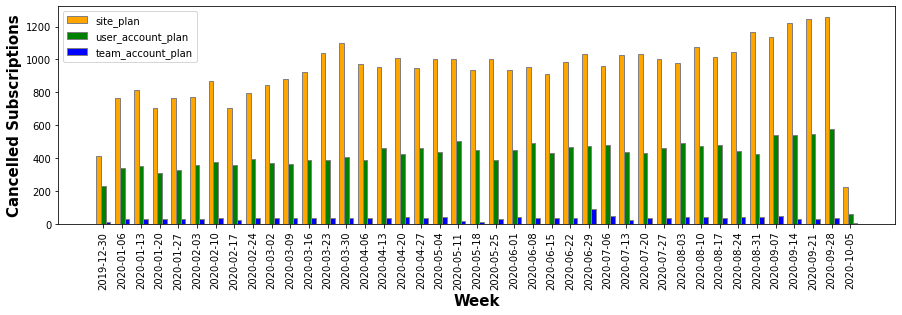

In [68]:
barWidth = 0.25
fig = plt.subplots(figsize =(15, 4))

# Set position of bar on X axis
br1 = np.arange(41)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
# br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, df_plan[df_plan['PLAN_OBJECT_TYPE']=='site_plan']['SUBSCR_COUNTS'], color ='orange', width = barWidth,
        edgecolor ='grey', label ='site_plan')
plt.bar(br2, df_plan[df_plan['PLAN_OBJECT_TYPE']=='user_account_plan']['SUBSCR_COUNTS'], color ='g', width = barWidth,
        edgecolor ='grey', label ='user_account_plan')
plt.bar(br3, df_plan[df_plan['PLAN_OBJECT_TYPE']=='team_account_plan']['SUBSCR_COUNTS'], color ='b', width = barWidth,
        edgecolor ='grey', label ='team_account_plan')
# plt.bar(br4, df_plan[df_plan['PLAN_OBJECT_TYPE']=='enterprise_plan']['SUBSCR_COUNTS'], color ='y', width = barWidth,
#         edgecolor ='grey', label ='enterprise_plan')
 
# Adding Xticks
plt.xlabel('Week', fontweight ='bold', fontsize = 15)
plt.ylabel('Cancelled Subscriptions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(41)], df_plan_week, fontsize = 10, rotation = 90 )
 
plt.tick_params(axis='x', which='major', labelsize = 10)
plt.legend(fontsize = 10)
plt.show()


### 5. Cancellations by Tenure

In [54]:
df_plan_ten = weekly_plan_cust_cancel.groupby(['WEEK','CUST_TENURE_BUCKET'])['SUBSCRIPTION_ID'].size().reset_index(name='SUBSCR_COUNTS')
# df_cust_tenure11.head(75)
df_plan_ten.head(5)

,WEEK,CUST_TENURE_BUCKET,SUBSCR_COUNTS
0,2019-12-30,0-3,283
1,2019-12-30,3-6,107
2,2019-12-30,6-9,55
3,2019-12-30,9-12,51
4,2019-12-30,12-18,89


In [55]:
df_plan_week = df_plan_ten.drop_duplicates(['WEEK']).sort_values(by = ['WEEK'])['WEEK']
df_plan_ten.head(5)

,WEEK,CUST_TENURE_BUCKET,SUBSCR_COUNTS
0,2019-12-30,0-3,283
1,2019-12-30,3-6,107
2,2019-12-30,6-9,55
3,2019-12-30,9-12,51
4,2019-12-30,12-18,89


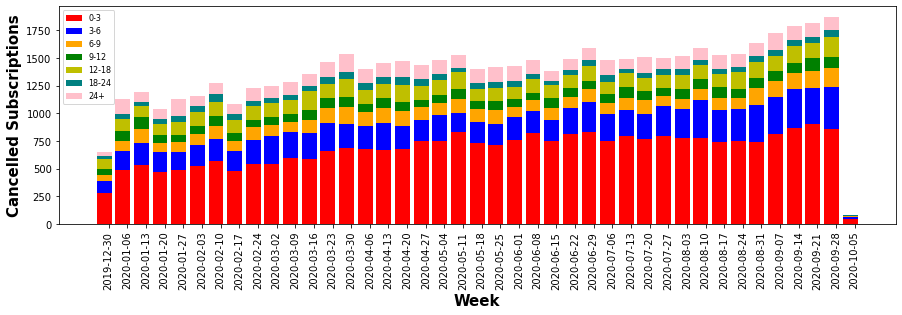

In [59]:
fig = plt.subplots(figsize =(15, 4))
  
# create data
x = df_plan_week
y1 = np.array(df_plan_ten[df_plan_ten['CUST_TENURE_BUCKET']=='0-3']['SUBSCR_COUNTS'])
y2 = np.array(df_plan_ten[df_plan_ten['CUST_TENURE_BUCKET']=='3-6']['SUBSCR_COUNTS'])
y3 = np.array(df_plan_ten[df_plan_ten['CUST_TENURE_BUCKET']=='6-9']['SUBSCR_COUNTS'])
y4 = np.array(df_plan_ten[df_plan_ten['CUST_TENURE_BUCKET']=='9-12']['SUBSCR_COUNTS'])
y5 = np.array(df_plan_ten[df_plan_ten['CUST_TENURE_BUCKET']=='12-18']['SUBSCR_COUNTS'])
y6 = np.array(df_plan_ten[df_plan_ten['CUST_TENURE_BUCKET']=='18-24']['SUBSCR_COUNTS'])
y7 = np.array(df_plan_ten[df_plan_ten['CUST_TENURE_BUCKET']=='24+']['SUBSCR_COUNTS'])
  
# plot bars in stack manner
plt.bar(x, y1, color='r')
plt.bar(x, y2, bottom=y1, color='b')
plt.bar(x, y3, bottom=y1+y2, color='orange')
plt.bar(x, y4, bottom=y1+y2+y3, color='green')
plt.bar(x, y5, bottom=y1+y2+y3+y4, color='y')
plt.bar(x, y6, bottom=y1+y2+y3+y4+y5, color='teal')
plt.bar(x, y7, bottom=y1+y2+y3+y4+y5+y6, color='pink')

plt.xlabel('Week', fontweight ='bold', fontsize = 15)
plt.ylabel('Cancelled Subscriptions', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(41)], df_plan_week, fontsize = 15, rotation = 90 )
 
plt.tick_params(axis='x', which='major', labelsize = 10)
plt.legend(['0-3', '3-6', '6-9', '9-12','12-18', '18-24', '24+'], loc = 'upper left', fontsize = 8)


plt.show()